# GAN 간단 실습

In [25]:
from tensorflow.keras.datasets import mnist

In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [27]:
# 정규화
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

In [28]:
x_train.min(), x_train.max()

(-1.0, 1.0)

In [29]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

In [30]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# noise에 대한 dimension
NOISE_DIM = 10

adam = Adam(lr = 0.0002, beta_1 = 0.5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
# Generator(생성자) 만들기
generator = Sequential([
                        Dense(256, input_dim = NOISE_DIM),
                        LeakyReLU(0.2),
                        Dense(512),
                        LeakyReLU(0.2),
                        Dense(1024),
                        LeakyReLU(0.2),
                        Dense(28*28, activation = 'tanh')

])

In [33]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               2816      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 784)              

In [34]:
# Discriminator(판별자) 생성
discriminator = Sequential([
                            Dense(1024, input_shape = (784, ), kernel_initializer = RandomNormal(stddev = 0.02)),
                            LeakyReLU(0.2),
                            Dropout(0.3),
                            Dense(512),
                            LeakyReLU(0.2),
                            Dropout(0.3),
                            Dense(256),
                            LeakyReLU(0.2),
                            Dropout(0.3),
                            Dense(1, activation = 'sigmoid')
])

In [35]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)              

In [36]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = adam)

In [37]:
# GAN 모델 만들기
# discriminator는 학습을 하지 않도록 하며, GEN 모델에서는 generator만 학습하도록 한다.
discriminator.trainable = False
gan_input = Input(shape = (NOISE_DIM,))
x = generator(inputs = gan_input)
output = discriminator(x)

In [38]:
gan = Model(gan_input, output)

In [39]:
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 sequential_2 (Sequential)   (None, 784)               1463312   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


In [40]:
gan.compile(loss = 'binary_crossentropy', optimizer = adam)

In [46]:
# GAN 모델 학습
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [50]:
def visualize_training(epoch, d_losses, g_losses):
    plt.figure(figsize = (8, 4))
    plt.plot(d_losses, label = 'Discriminator Loss')
    plt.plot(g_losses, label = 'Generator Loss')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size = (24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)

    plt.figure(figsize = (8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [48]:
BATCH_SIZE = 128
EPOCHS = 50

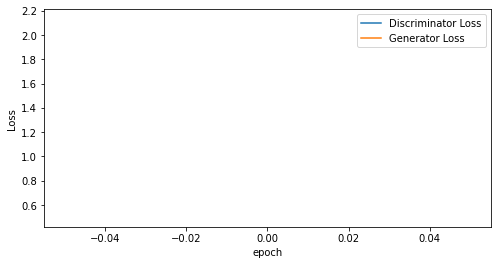

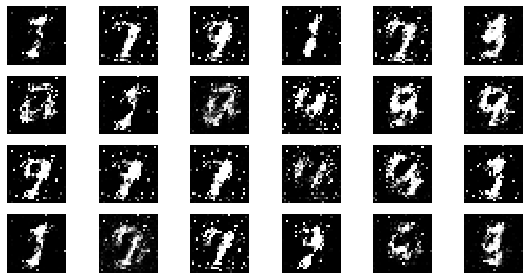

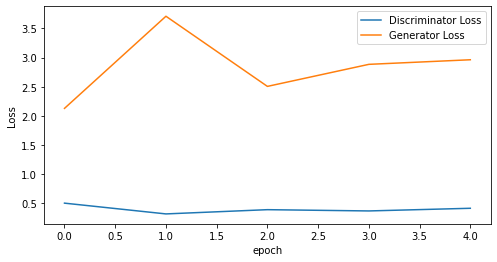

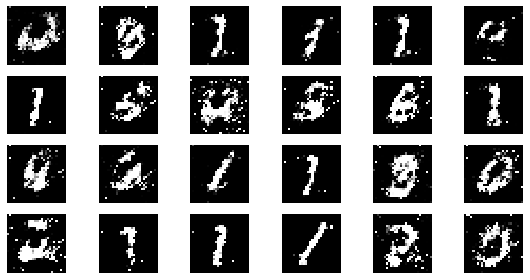

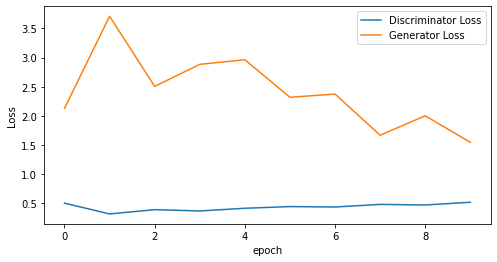

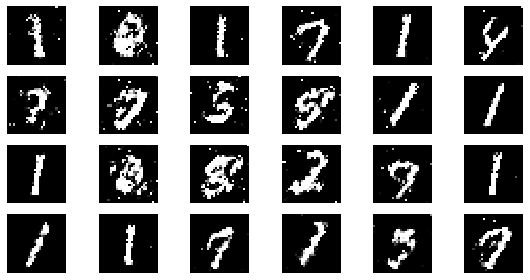

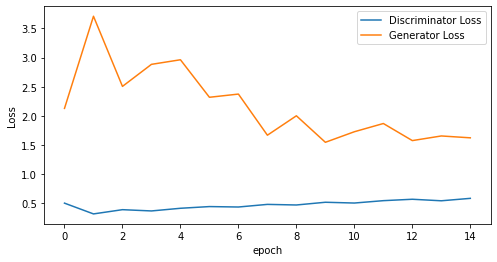

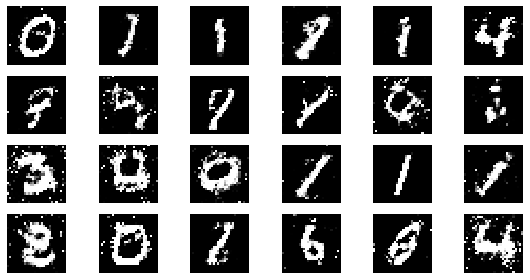

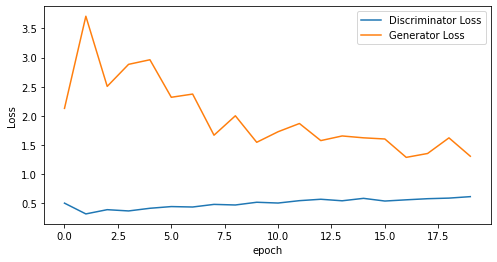

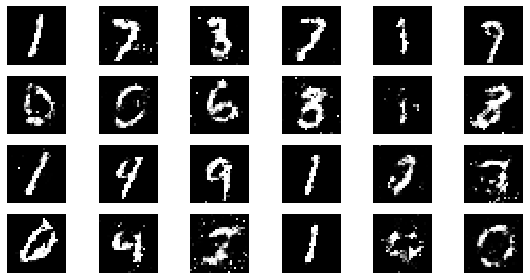

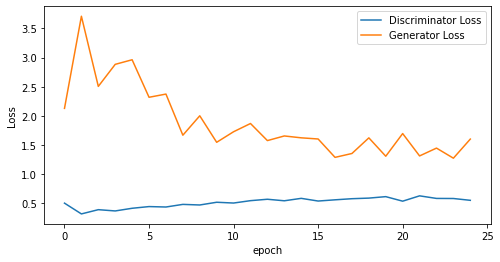

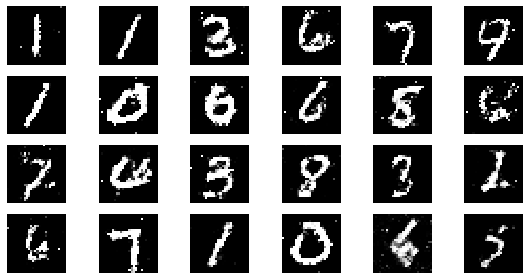

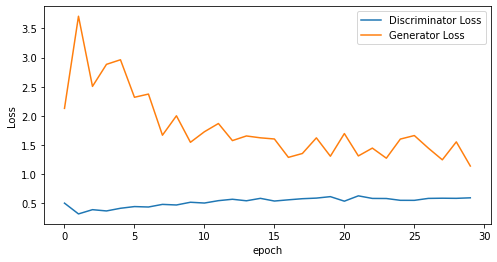

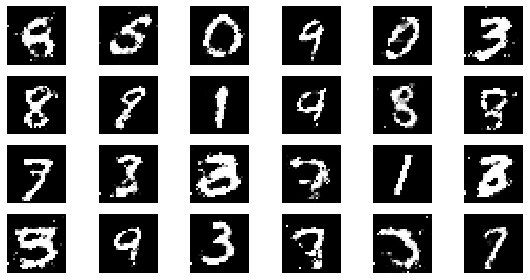

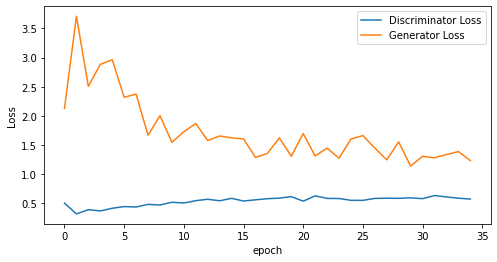

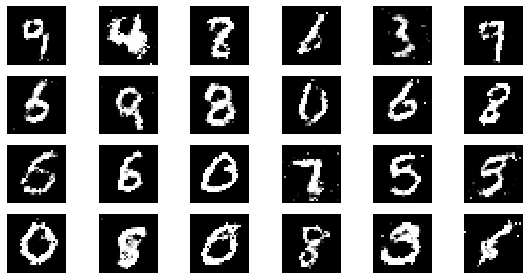

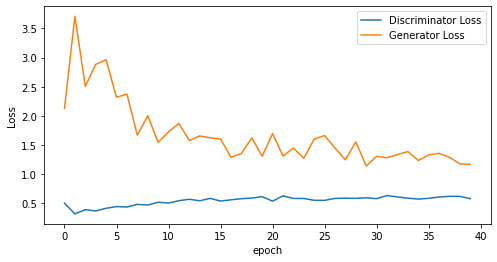

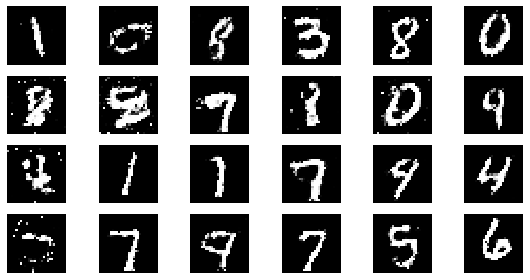

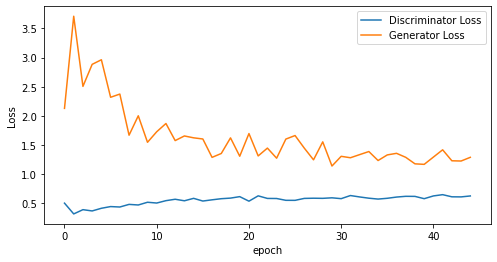

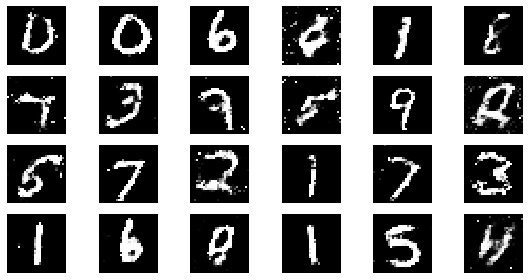

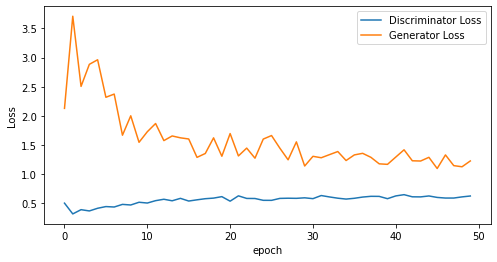

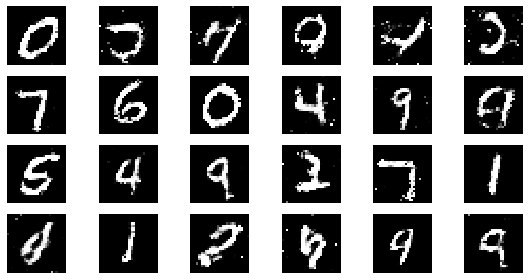

In [51]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)

# DCGAN 실습

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [53]:
from keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()

170508288/170498071 [==============================] - 6s 0us/step


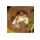

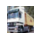

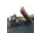

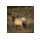

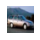

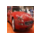

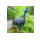

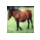

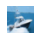

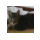

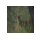

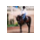

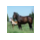

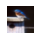

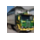

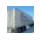

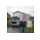

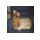

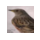

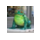

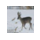

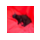

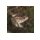

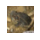

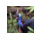

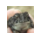

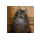

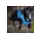

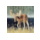

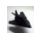

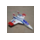

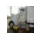

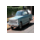

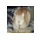

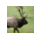

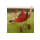

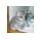

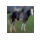

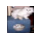

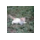

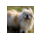

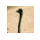

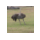

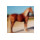

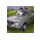

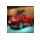

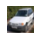

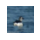

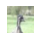

In [54]:
# 이미지 확인
for i in range(49):
    plt.subplot(7, 7, 1 + i)
    plt.axis('off')
    plt.imshow(X_train[i])
    plt.show()

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose
from keras.utils.vis_utils import plot_model

In [57]:
# discriminator 모델 구조 생성 함수
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [58]:
model = define_discriminator()

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


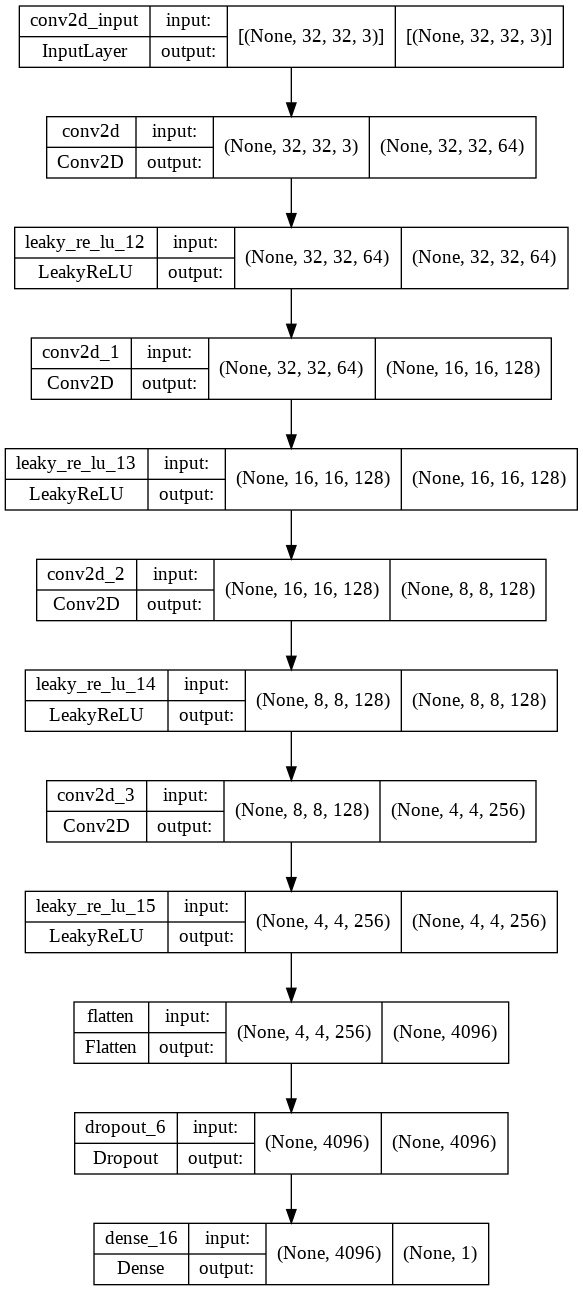

In [59]:
plot_model(model, to_file = 'discriminator_plot.png', show_shapes = True, show_layer_names = True)

In [60]:
# real sample 생성 함수
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [61]:

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [80]:
# fake samples 생성
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(32 * 32 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 32, 32, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [77]:

# example of training the discriminator model on real and random cifar10 images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

In [94]:

# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 

In [78]:

# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [81]:
# discriminator 모델 정의
model = define_discriminator()
dataset = load_real_samples()

train_discriminator(model, dataset)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1 real=34% fake=5%
>2 real=91% fake=17%
>3 real=94% fake=39%
>4 real=81% fake=81%
>5 real=81% fake=100%
>6 real=77% fake=100%
>7 real=89% fake=100%
>8 real=84% fake=100%
>9 real=88% fake=100%
>10 real=89% fake=100%
>11 real=92% fake=100%
>12 real=100% fake=100%
>13 real=98% fake=100%
>14 real=100% fake=100%
>15 real=97% fake=100%
>16 real=98% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


In [83]:
# generator 생성 함수

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

In [90]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 4096)              413696    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                           

In [91]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [92]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

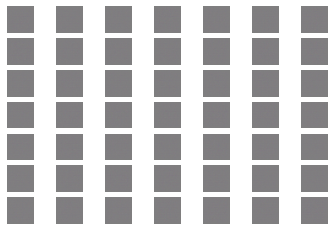

In [95]:
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i])
# show the figure
pyplot.show()

In [96]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 32, 32, 3)         1466115   
                                                                 
 sequential_13 (Sequential)  (None, 1)                 522497    
                                                                 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


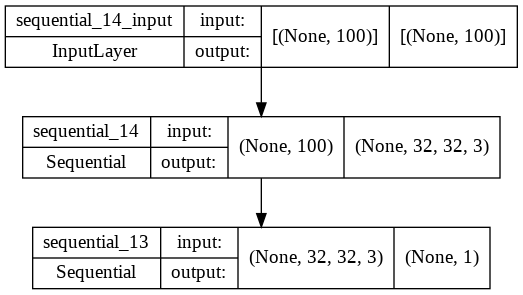

In [97]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [98]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [99]:

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [100]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [101]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
>59, 134/390, d1=0.663, d2=0.618 g=0.941
>59, 135/390, d1=0.719, d2=0.580 g=0.967
>59, 136/390, d1=0.682, d2=0.585 g=0.978
>59, 137/390, d1=0.679, d2=0.636 g=0.928
>59, 138/390, d1=0.635, d2=0.683 g=0.869
>59, 139/390, d1=0.679, d2=0.716 g=0.813
>59, 140/390, d1=0.686, d2=0.629 g=0.844
>59, 141/390, d1=0.679, d2=0.659 g=0.852
>59, 142/390, d1=0.659, d2=0.659 g=0.873
>59, 143/390, d1=0.596, d2=0.610 g=0.878
>59, 144/390, d1=0.644, d2=0.648 g=0.839
>59, 145/390, d1=0.531, d2=0.701 g=0.903
>59, 146/390, d1=0.649, d2=0.594 g=0.888
>59, 147/390, d1=0.702, d2=0.619 g=0.881
>59, 148/390, d1=0.675, d2=0.679 g=0.905
>59, 149/390, d1=0.617, d2=0.702 g=0.916
>59, 150/390, d1=0.651, d2=0.590 g=0.928
>59, 151/390, d1=0.690, d2=0.648 g=0.947
>59, 152/390, d1=0.631, d2=0.580 g=0.946
>59, 153/390, d1=0.715, d2=0.616 g=0.915
>59, 154/390, d1=0.623, d2=0.607 g=0.847
>59, 155/390, d1=0.668, d2=0.638 g=0.907
>59, 156/390, d1=0.700, d2=0.624 g=0.847
>59, 157/390, d1=0.61

In [ ]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

In [ ]:

# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('generator_model_200.h5')
# all 0s
vector = asarray([[0.75 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()